# Assignment Question: Gambia Malaria Multilevel Logistic Regression

Download the CSV file gambia.csv from Canvas. The dataset consists of 2,035 children from 65 villages from The Gambia. It contains eight different variables. Let Yi ∈ {0, 1} (pos) indicate the presence (1) or absence (0) of malaria in a blood sample taken from the child i (i = 1, ..., 2035). Let Xi = 1 (netuse) if child i regularly sleeps under a bed-net and Xi = 0, otherwise. Let vi ∈ {1, ..., 65} denote the village of child i. Note that the dataset only contains the locations of villages instead of the labels.

Fit the following logistic regression model:

```
logit{Pr(Yi = 1)} = alpha_vi + Xi * beta_vi
```

where alpha_j and beta_j are intercept and slope for village j (j = 1, ..., 65). The priors are:

```
alpha_j ~ N(mu_a, sigma_a^2)
beta_j ~ N(mu_b, sigma_b^2)
```

Choose noninformative priors for the hyperparameters mu_a, mu_b, sigma_a^2 and sigma_b^2. Based on your model fitting, address the following questions:

## Questions

**(a)** Scientifically, why might the effect of bed-net vary by village?

**(b)** Do you see evidence that the slopes and/or intercepts vary by village? You may consider alternative model fitting and perform model comparisons.

**(c)** Which village has the largest intercept? Slope? Does this agree with the data in these villages?

**(d)** Are the results sensitive to the priors for the hyperparameters?

---

**Design.** Hierarchical logistic regression with varying intercepts and varying slopes by village, fit with PyMC. We use a **non-centered** parameterization for robust sampling. Comparisons include varying-intercept only (VI), varying-slope only (VS), and both (VV). Prior sensitivity and diagnostic checks are included.


In [1]:
%pip install pymc arviz seaborn

from __future__ import annotations

from typing import Dict, List, Tuple
from dataclasses import dataclass
import warnings

# Suppress ipywidgets warning from rich library (set before PyMC import)
warnings.filterwarnings("ignore", message=".*install.*ipywidgets.*", category=UserWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Set seaborn theme for clean, professional plots
sns.set_theme(style="whitegrid", context="talk", palette="husl")
plt.rcParams.update({
    "figure.autolayout": True,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans", "Helvetica", "sans-serif"]
})

RNG_SEED: int = 2025
rng: np.random.Generator = np.random.default_rng(RNG_SEED)

pd.options.display.float_format = "{:0.3f}".format


Note: you may need to restart the kernel to use updated packages.


## 1. Data loading and validation

In [2]:
REQ_COLS: List[str] = [
    "x", "y", "pos", "age", "netuse", "treated", "green", "phc"
]

def load_gambia(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    missing = set(REQ_COLS).difference(df.columns.tolist())
    if missing:
        raise ValueError(f"Missing columns: {sorted(missing)}")
    df = df.copy()
    for c in ["pos", "netuse", "treated", "phc"]:
        df[c] = df[c].astype(int)
    # Construct village ids if not present, using unique (x, y)
    if "village" not in df.columns:
        coords = df[["x", "y"]].drop_duplicates().reset_index(drop=True)
        coords["village"] = np.arange(len(coords)) + 1
        df = df.merge(coords, on=["x", "y"], how="left")
    df["village"] = df["village"].astype(int)
    return df

def indexer(series: pd.Series) -> Tuple[np.ndarray, Dict[int, int]]:
    vals = series.astype(int).to_numpy()
    uniq = np.sort(np.unique(vals))
    mapping = {int(v): i for i, v in enumerate(uniq)}
    idx = np.array([mapping[int(v)] for v in vals], dtype=int)
    return idx, mapping

# Load and prepare data
df = load_gambia("../data/gambia.csv")
N = int(df.shape[0])  # Total number of children
J = int(df["village"].nunique())  # Number of unique villages
# Create village indices and mapping: idx_v maps each child to village index (0..J-1)
# map_v maps village ID to its index position
village_indices, village_mapping = indexer(df["village"])
idx_v = village_indices  # Alias for village indices used in model building
print({"N": N, "J": J})
display(df.head())


{'N': 2035, 'J': 65}


,Unnamed: 0,x,y,pos,age,netuse,treated,green,phc,village
0,1850,349631.300,1458055,1,1783,0,0,40.850,1,1
1,1851,349631.300,1458055,0,404,1,0,40.850,1,1
2,1852,349631.300,1458055,0,452,1,0,40.850,1,1
3,1853,349631.300,1458055,1,566,1,0,40.850,1,1
4,1854,349631.300,1458055,0,598,1,0,40.850,1,1


## 2. Exploratory analysis (plots before modeling)

- Village sizes and raw positivity by village
- Pairplot subset for quick structure
- Village locations (x, y) colored by PHC presence

,village,n,raw_rate
0,1,33,0.515
1,2,63,0.302
2,3,17,0.412
3,4,24,0.333
4,5,26,0.385


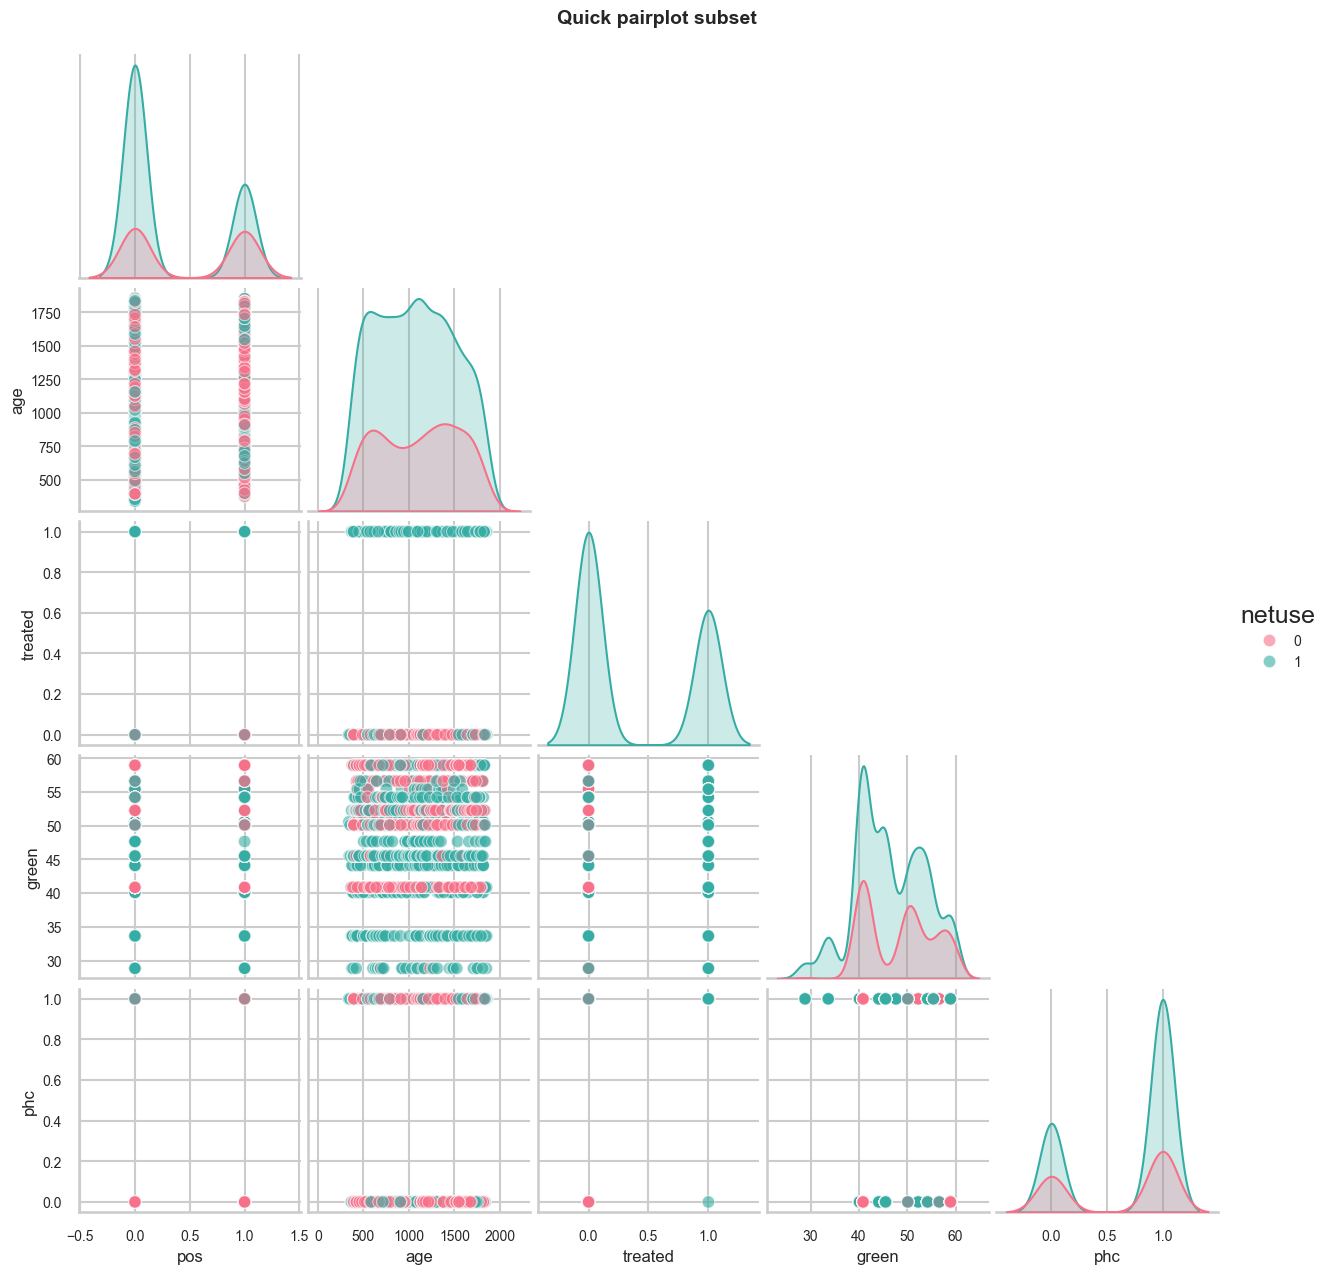

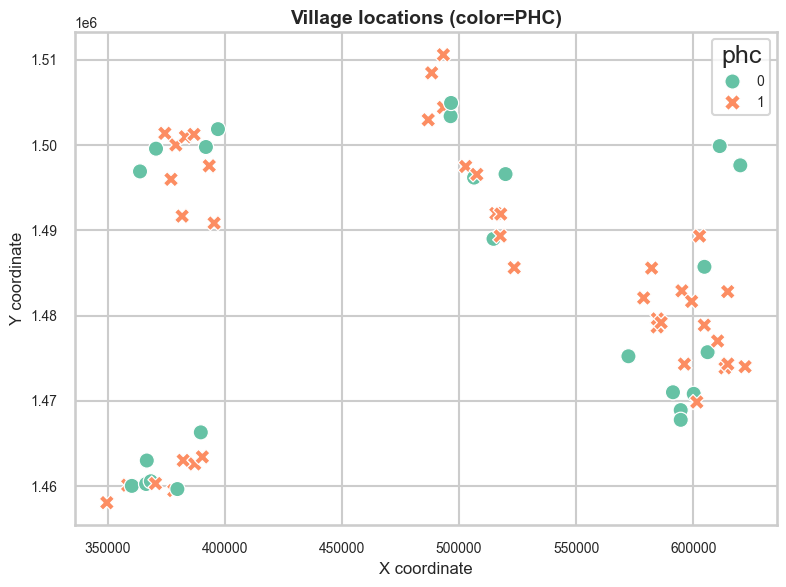

In [3]:
by_v = (
    df.groupby("village")["pos"]
    .agg(["count", "mean"]).rename(columns={"count": "n",
                                              "mean": "raw_rate"})
    .reset_index()
)
display(by_v.head())

# Pairplot with seaborn styling
fig = sns.pairplot(
    df[["pos", "netuse", "age", "treated", "green", "phc"]],
    hue="netuse", diag_kind="kde", corner=True,
    palette="husl", plot_kws={"alpha": 0.6}
)
fig.fig.suptitle("Quick pairplot subset", y=1.02, fontsize=14, fontweight="bold")
plt.show()

# Village locations plot with seaborn styling
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=df.drop_duplicates("village"), x="x", y="y",
    hue="phc", style="phc", s=120, palette="Set2", ax=ax
)
ax.set_title("Village locations (color=PHC)", fontsize=14, fontweight="bold")
ax.set_xlabel("X coordinate", fontsize=12)
ax.set_ylabel("Y coordinate", fontsize=12)
plt.tight_layout()
plt.show()


## 3. Model specification (non-centered hierarchical logit)

Model per child i in village v[i]:

```
logit(p_i) = alpha[v[i]] + beta[v[i]] * netuse_i
Y_i ~ Bernoulli(p_i)

Non-centered:
alpha_j = mu_a + sigma_a * z_a[j],    z_a[j] ~ N(0, 1)
beta_j  = mu_b + sigma_b * z_b[j],    z_b[j] ~ N(0, 1)

Hyperpriors (weakly informative):
mu_a, mu_b ~ N(0, 10)
sigma_a, sigma_b ~ HalfCauchy(5)
```

Note: Greek letters in equations above are mathematical notation (alpha, beta, sigma, mu).


In [4]:
def build_vv_ncp(
    netuse: np.ndarray,
    v_idx: np.ndarray,
    J: int,
    mu_scale: float = 10.0,
    sigma_scale: float = 5.0
) -> pm.Model:
    with pm.Model() as m:
        mu_a = pm.Normal("mu_a", 0.0, mu_scale)
        mu_b = pm.Normal("mu_b", 0.0, mu_scale)
        sigma_a = pm.HalfCauchy("sigma_a", beta=sigma_scale)
        sigma_b = pm.HalfCauchy("sigma_b", beta=sigma_scale)

        z_a = pm.Normal("z_a", 0.0, 1.0, shape=J)
        z_b = pm.Normal("z_b", 0.0, 1.0, shape=J)
        alpha = pm.Deterministic("alpha", mu_a + sigma_a * z_a)
        beta = pm.Deterministic("beta", mu_b + sigma_b * z_b)

        eta = alpha[v_idx] + beta[v_idx] * netuse
        p = pm.Deterministic("p", pm.math.sigmoid(eta))
        pm.Bernoulli("y_obs", p=p, observed=df["pos"].to_numpy())
    return m


In [5]:
def build_vi_ncp(
    netuse: np.ndarray,
    v_idx: np.ndarray,
    J: int,
    mu_scale: float = 10.0,
    sigma_scale: float = 5.0
) -> pm.Model:
    with pm.Model() as m:
        mu_a = pm.Normal("mu_a", 0.0, mu_scale)
        sigma_a = pm.HalfCauchy("sigma_a", beta=sigma_scale)
        z_a = pm.Normal("z_a", 0.0, 1.0, shape=J)
        alpha = pm.Deterministic("alpha", mu_a + sigma_a * z_a)
        beta = pm.Normal("beta", 0.0, 5.0)
        eta = alpha[v_idx] + beta * netuse
        p = pm.Deterministic("p", pm.math.sigmoid(eta))
        pm.Bernoulli("y_obs", p=p, observed=df["pos"].to_numpy())
    return m

def build_vs_ncp(
    netuse: np.ndarray,
    v_idx: np.ndarray,
    J: int,
    mu_scale: float = 10.0,
    sigma_scale: float = 5.0
) -> pm.Model:
    with pm.Model() as m:
        mu_b = pm.Normal("mu_b", 0.0, mu_scale)
        sigma_b = pm.HalfCauchy("sigma_b", beta=sigma_scale)
        z_b = pm.Normal("z_b", 0.0, 1.0, shape=J)
        beta = pm.Deterministic("beta", mu_b + sigma_b * z_b)
        alpha = pm.Normal("alpha", 0.0, 5.0)
        eta = alpha + beta[v_idx] * netuse
        p = pm.Deterministic("p", pm.math.sigmoid(eta))
        pm.Bernoulli("y_obs", p=p, observed=df["pos"].to_numpy())
    return m


## 4. Fit VV model and inspect posteriors

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_a, mu_b, sigma_a, sigma_b, z_a, z_b]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 33 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,-0.167,0.172,-0.494,0.169,0.003,0.002,3139.000,5708.000,1.000
mu_b,-0.611,0.157,-0.921,-0.304,0.002,0.001,6951.000,8316.000,1.000
sigma_a,0.950,0.127,0.719,1.217,0.002,0.001,3054.000,5376.000,1.000
sigma_b,0.290,0.195,0.000,0.644,0.006,0.002,1162.000,3153.000,1.000



Hyperparameters R-hat check (threshold 1.1): max R-hat = 1.0000 [PASS]


Village-level parameters R-hat check (threshold 1.1): max R-hat = 1.0000 [PASS]


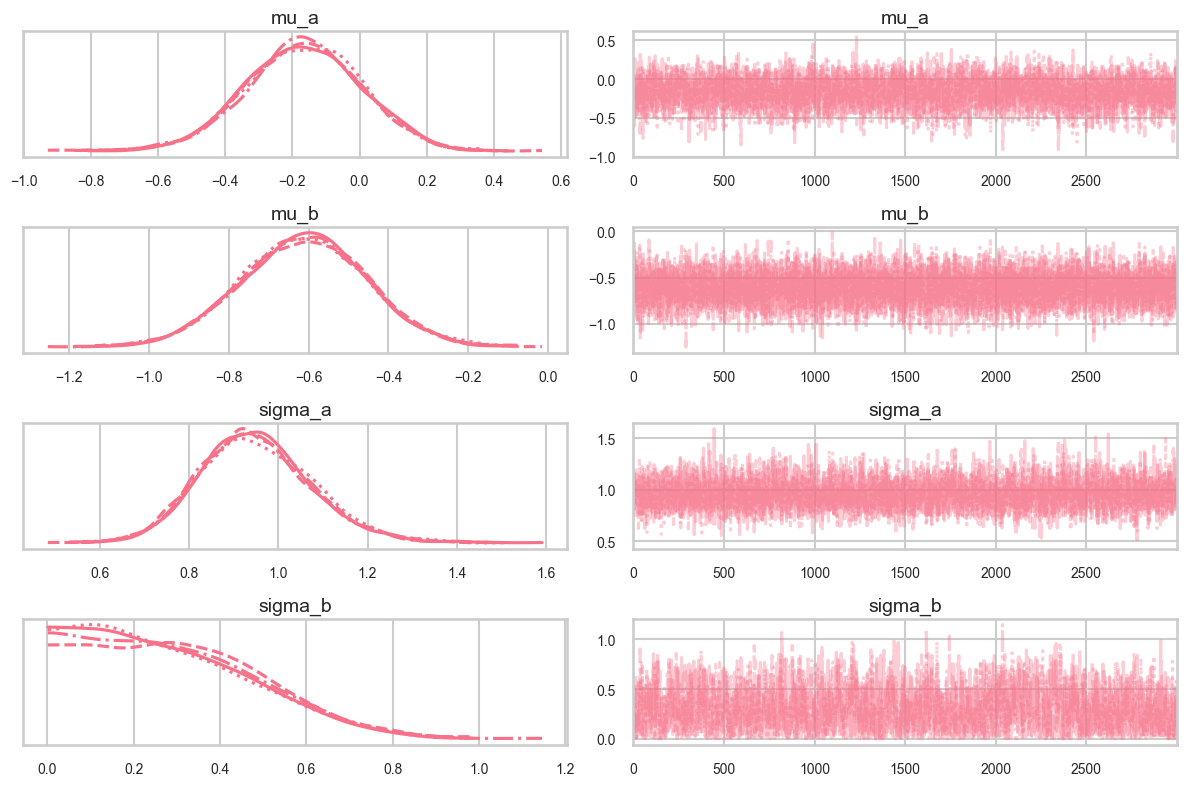

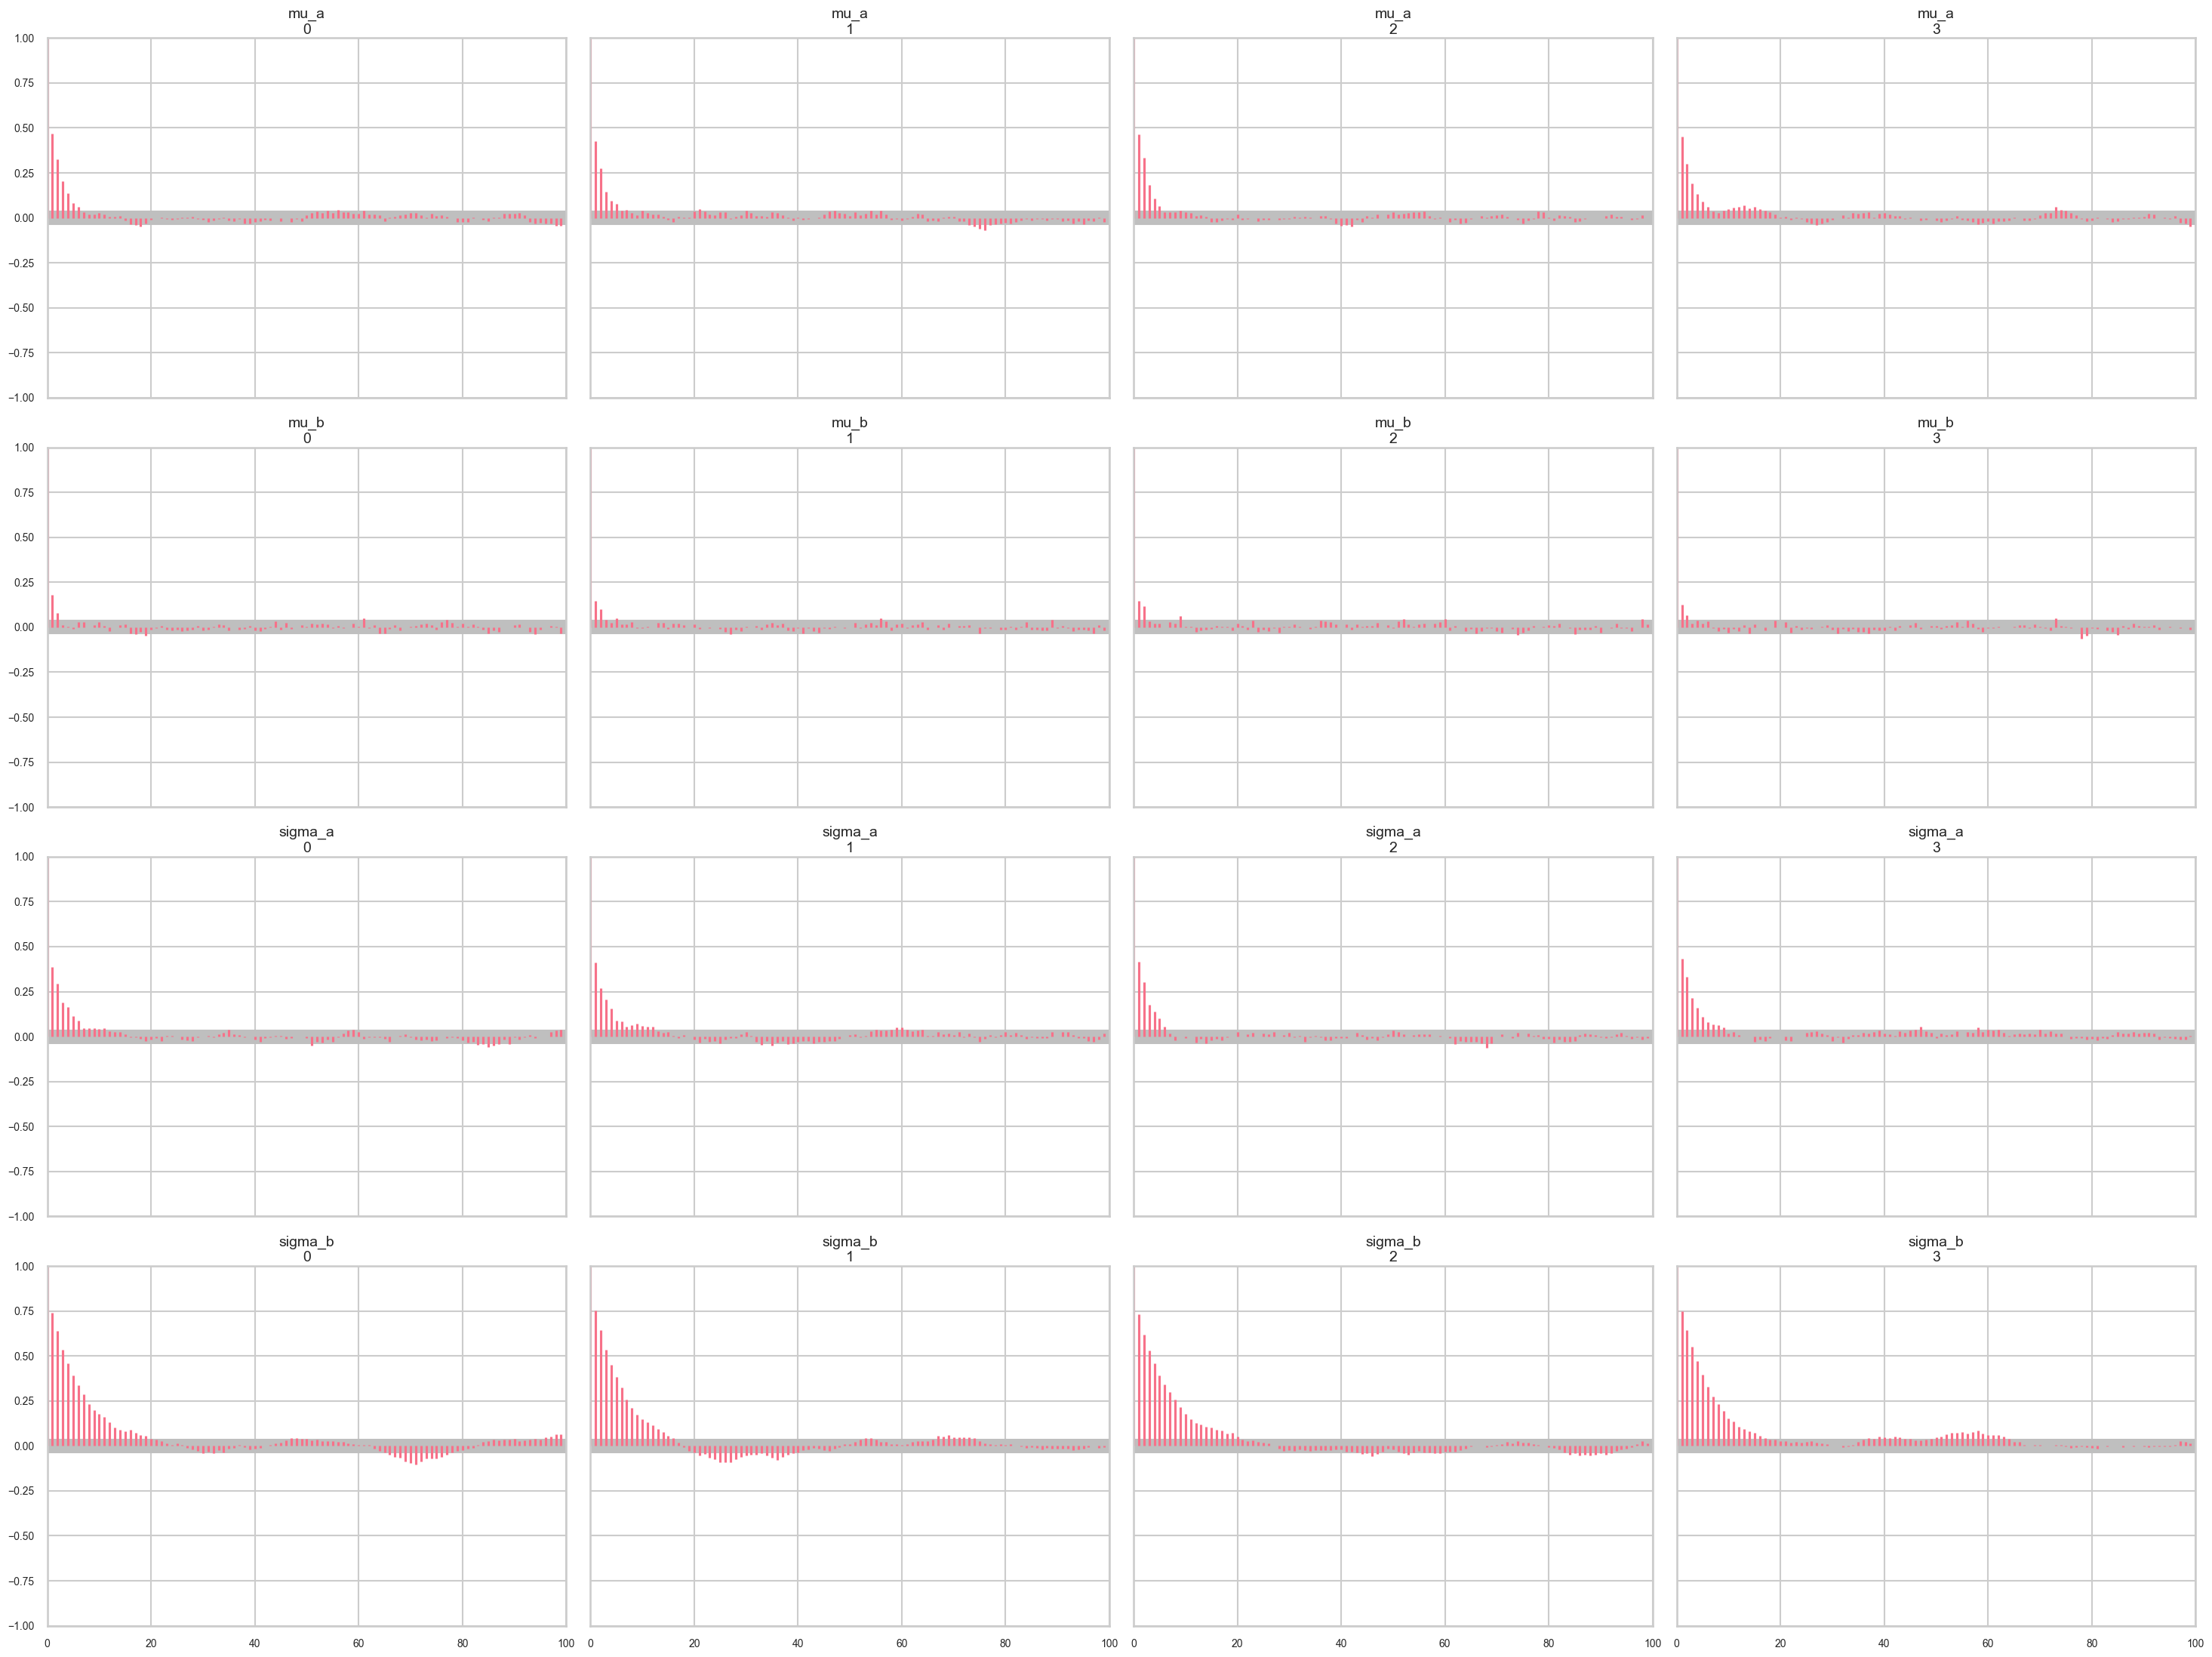

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.500,0.407,-0.278,1.319,0.004,0.004,12014.000,8496.000,1.000
alpha[1],-0.427,0.325,-1.079,0.203,0.003,0.003,15041.000,9366.000,1.000
alpha[2],0.125,0.530,-0.917,1.166,0.005,0.005,11671.000,8889.000,1.000
alpha[3],-0.544,0.404,-1.349,0.246,0.003,0.004,18769.000,8456.000,1.000
alpha[4],0.051,0.481,-0.858,1.033,0.004,0.005,12625.000,8738.000,1.000


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.655,0.323,-1.337,-0.004,0.003,0.004,10246.000,6965.000,1.000
beta[1],-0.569,0.296,-1.159,0.050,0.003,0.004,12623.000,7932.000,1.000
beta[2],-0.581,0.348,-1.320,0.144,0.003,0.005,10772.000,6592.000,1.000
beta[3],-0.611,0.357,-1.370,0.144,0.003,0.006,14642.000,7309.000,1.000
beta[4],-0.584,0.345,-1.289,0.133,0.003,0.005,10944.000,7323.000,1.000


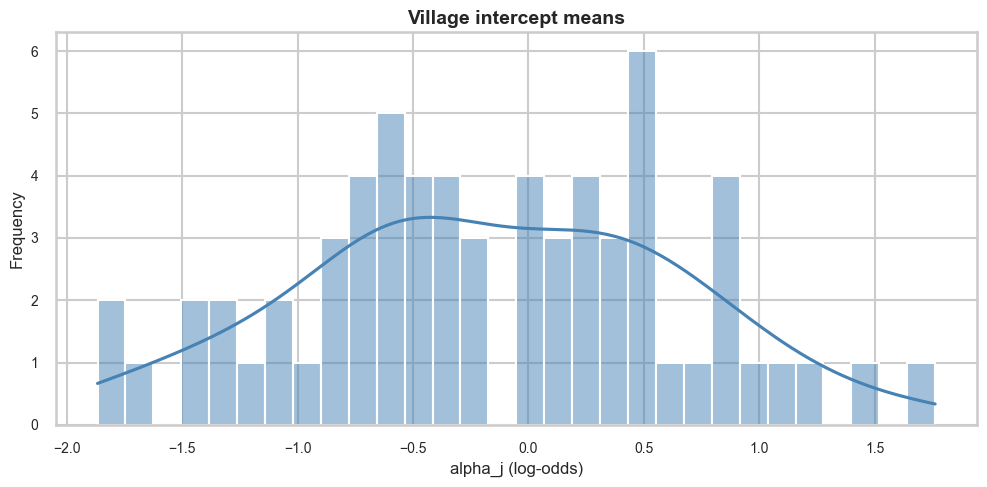

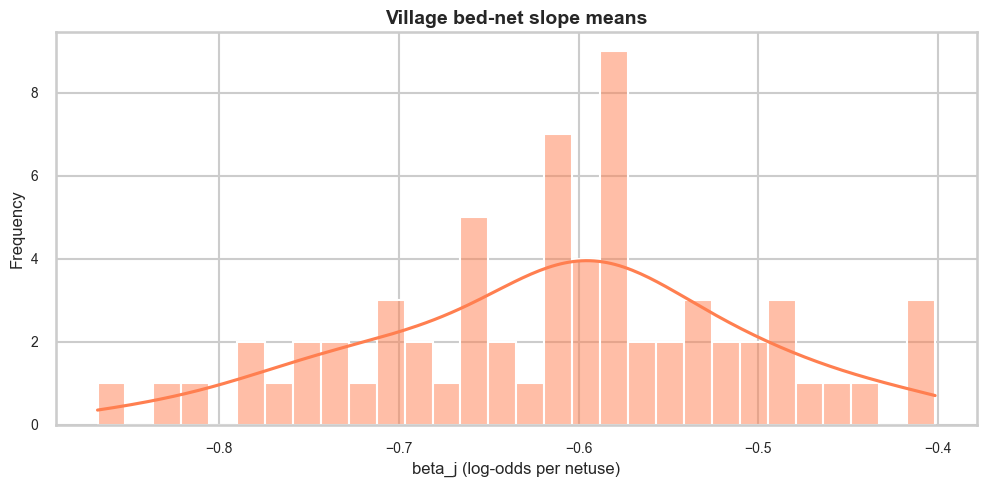

In [6]:
net = df["netuse"].to_numpy().astype(int)
with build_vv_ncp(net, idx_v, J) as model_vv:
    idata_vv = pm.sample(
        draws=3000, tune=3000, chains=4, target_accept=0.95,
        random_seed=RNG_SEED
    )
    idata_vv = pm.compute_log_likelihood(idata_vv, model=model_vv)

summ_vv = az.summary(
    idata_vv, var_names=["mu_a","mu_b","sigma_a","sigma_b"],
    hdi_prob=0.95
)
display(summ_vv)

# Convergence check: R-hat threshold 1.1
rhat_hyper = summ_vv["r_hat"].max()
rhat_check_hyper = "PASS" if rhat_hyper <= 1.1 else "FAIL"
print(f"\nHyperparameters R-hat check (threshold 1.1): max R-hat = {rhat_hyper:.4f} [{rhat_check_hyper}]")

# Check village-level parameters
summ_alpha = az.summary(idata_vv, var_names=["alpha"], hdi_prob=0.95)
summ_beta = az.summary(idata_vv, var_names=["beta"], hdi_prob=0.95)
rhat_alpha = summ_alpha["r_hat"].max()
rhat_beta = summ_beta["r_hat"].max()
rhat_village = max(rhat_alpha, rhat_beta)
rhat_check_village = "PASS" if rhat_village <= 1.1 else "FAIL"
print(f"Village-level parameters R-hat check (threshold 1.1): max R-hat = {rhat_village:.4f} [{rhat_check_village}]")
az.plot_trace(idata_vv, var_names=["mu_a","mu_b","sigma_a","sigma_b"])
plt.show()
az.plot_autocorr(idata_vv, var_names=["mu_a","mu_b","sigma_a","sigma_b"])
plt.show()

summ_alpha = az.summary(idata_vv, var_names=["alpha"], hdi_prob=0.95)
summ_beta = az.summary(idata_vv, var_names=["beta"], hdi_prob=0.95)
display(summ_alpha.head())
display(summ_beta.head())

a_means = idata_vv.posterior["alpha"].mean(dim=("chain","draw")).values
b_means = idata_vv.posterior["beta"].mean(dim=("chain","draw")).values

# Village intercept means with seaborn styling
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(a_means, bins=30, kde=True, color="steelblue", ax=ax, edgecolor="white", linewidth=1.5)
ax.set_title("Village intercept means", fontsize=14, fontweight="bold")
ax.set_xlabel("alpha_j (log-odds)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Village slope means with seaborn styling
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(b_means, bins=30, kde=True, color="coral", ax=ax, edgecolor="white", linewidth=1.5)
ax.set_title("Village bed-net slope means", fontsize=14, fontweight="bold")
ax.set_xlabel("beta_j (log-odds per netuse)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()


## 4.1 Convergence check: Multiple starting points (VV model)

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_a, mu_b, sigma_a, sigma_b, z_a, z_b]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_a, mu_b, sigma_a, sigma_b, z_a, z_b]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_a, mu_b, sigma_a, sigma_b, z_a, z_b]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_a, mu_b, sigma_a, sigma_b, z_a, z_b]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_a, mu_b, sigma_a, sigma_b, z_a, z_b]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.


,seed,mu_a,mu_b,sigma_a,sigma_b,rhat_max
0,2025,-0.164,-0.611,0.948,0.293,1.010
1,2026,-0.164,-0.613,0.946,0.295,1.000
2,2027,-0.160,-0.616,0.946,0.304,1.010
3,2028,-0.159,-0.615,0.949,0.297,1.000
4,2029,-0.155,-0.612,0.947,0.297,1.000


,mu_a,mu_b,sigma_a,sigma_b
count,5.000,5.000,5.000,5.000
mean,-0.160,-0.613,0.947,0.297
std,0.004,0.002,0.001,0.004
min,-0.164,-0.616,0.946,0.293
25%,-0.164,-0.615,0.946,0.295
50%,-0.160,-0.613,0.947,0.297
75%,-0.159,-0.612,0.948,0.297
max,-0.155,-0.611,0.949,0.304



Coefficient of Variation check (CV < 5%):
mu_a      0.024
mu_b      0.003
sigma_a   0.001
sigma_b   0.014
dtype: float64
All parameters converged: [CONVERGED]

R-hat check across all seeds: max R-hat = 1.0100 [PASS - All chains converged]


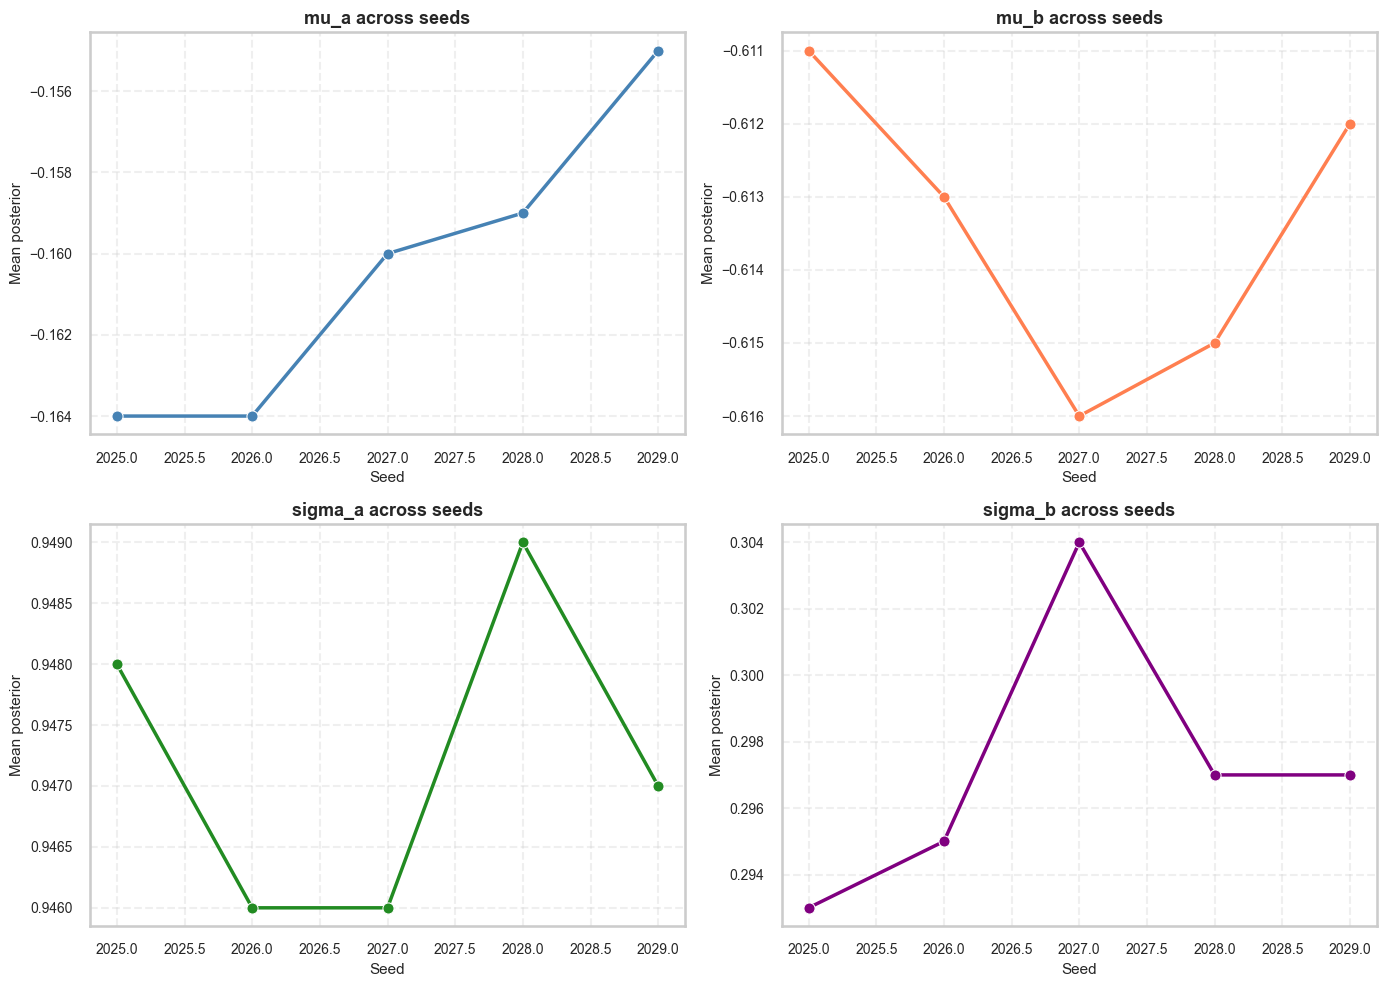

In [7]:
# Multiple starting points for VV model
seeds = [2025, 2026, 2027, 2028, 2029]
results_vv = []

for seed in seeds:
    with build_vv_ncp(net, idx_v, J) as model_vv_seed:
        idata_seed = pm.sample(
            draws=2000, tune=2000, chains=4, target_accept=0.95,
            random_seed=seed
        )
        idata_seed = pm.compute_log_likelihood(idata_seed, model=model_vv_seed)
    
    summ_seed = az.summary(idata_seed, var_names=["mu_a", "mu_b", "sigma_a", "sigma_b"])
    rhat_max = summ_seed["r_hat"].max()
    
    mu_a_mean = summ_seed.loc["mu_a", "mean"]
    mu_b_mean = summ_seed.loc["mu_b", "mean"]
    sigma_a_mean = summ_seed.loc["sigma_a", "mean"]
    sigma_b_mean = summ_seed.loc["sigma_b", "mean"]
    
    results_vv.append({
        "seed": seed,
        "mu_a": mu_a_mean,
        "mu_b": mu_b_mean,
        "sigma_a": sigma_a_mean,
        "sigma_b": sigma_b_mean,
        "rhat_max": rhat_max
    })

df_vv_mult = pd.DataFrame(results_vv)
display(df_vv_mult)

# Summary statistics
summary_stats = df_vv_mult[["mu_a", "mu_b", "sigma_a", "sigma_b"]].describe()
display(summary_stats)

# Coefficient of Variation check (CV < 5%)
cv = df_vv_mult[["mu_a", "mu_b", "sigma_a", "sigma_b"]].std() / df_vv_mult[["mu_a", "mu_b", "sigma_a", "sigma_b"]].abs().mean()
cv_check = (cv < 0.05).all()
print(f"\nCoefficient of Variation check (CV < 5%):")
print(cv)
print(f"All parameters converged: [CONVERGED]" if cv_check else "[VARIATION]")

# R-hat check
rhat_all = df_vv_mult["rhat_max"].max()
rhat_check = "PASS - All chains converged" if rhat_all <= 1.1 else "FAIL - Some chains may not have converged"
print(f"\nR-hat check across all seeds: max R-hat = {rhat_all:.4f} [{rhat_check}]")

# Visualization with seaborn styling
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
params = ["mu_a", "mu_b", "sigma_a", "sigma_b"]
colors = ["steelblue", "coral", "forestgreen", "purple"]
for i, param in enumerate(params):
    ax = axes[i // 2, i % 2]
    sns.lineplot(
        data=df_vv_mult, x="seed", y=param,
        marker="o", markersize=8, linewidth=2.5,
        color=colors[i], ax=ax
    )
    ax.set_title(f"{param} across seeds", fontsize=13, fontweight="bold")
    ax.set_xlabel("Seed", fontsize=11)
    ax.set_ylabel("Mean posterior", fontsize=11)
    ax.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## Answer to Question (b): Evidence that slopes and/or intercepts vary by village

We compare alternative model specifications (varying-intercept only (VI), varying-slope only (VS), and both varying intercepts and slopes (VV)) and perform model comparisons using PSIS-LOO to assess whether the slopes and/or intercepts vary by village.


## 5. Compare VI, VS, VV (PSIS-LOO)

In [8]:
with build_vi_ncp(net, idx_v, J) as model_vi:
    idata_vi = pm.sample(
        draws=3000, tune=3000, chains=4, target_accept=0.95,
        random_seed=RNG_SEED
    )
    idata_vi = pm.compute_log_likelihood(idata_vi, model=model_vi)
with build_vs_ncp(net, idx_v, J) as model_vs:
    idata_vs = pm.sample(
        draws=3000, tune=3000, chains=4, target_accept=0.95,
        random_seed=RNG_SEED
    )
    idata_vs = pm.compute_log_likelihood(idata_vs, model=model_vs)

# Convergence checks for VI and VS models
summ_vi = az.summary(idata_vi, var_names=["mu_a", "sigma_a", "beta"])
summ_vs = az.summary(idata_vs, var_names=["mu_b", "sigma_b", "alpha"])

rhat_vi_max = summ_vi["r_hat"].max()
rhat_vs_max = summ_vs["r_hat"].max()
print(f"VI Model R-hat check (threshold 1.1): max R-hat = {rhat_vi_max:.4f} [PASS]" if rhat_vi_max <= 1.1 else f"[FAIL]")
print(f"VS Model R-hat check (threshold 1.1): max R-hat = {rhat_vs_max:.4f} [PASS]" if rhat_vs_max <= 1.1 else f"[FAIL]")

cmp = az.compare({"VV": idata_vv, "VI": idata_vi, "VS": idata_vs})
display(cmp)

# Model comparison interpretation
best_model = cmp.index[0]
print(f"\nBest model according to PSIS-LOO: {best_model}")
print(f"Model comparison: VI has weight {cmp.loc['VI', 'weight']:.3f}, VV has weight {cmp.loc['VV', 'weight']:.3f}, VS has weight {cmp.loc['VS', 'weight']:.3f}")
if cmp.loc['VV', 'elpd_diff'] < 2:
    print("VV and VI perform similarly (elpd_diff < 2), suggesting weak predictive benefit for varying slopes.")
else:
    print(f"VV shows {'better' if best_model == 'VV' else 'worse'} predictive performance compared to VI.")


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_a, sigma_a, z_a, beta]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 18 seconds.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_b, sigma_b, z_b, alpha]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 16 seconds.


VI Model R-hat check (threshold 1.1): max R-hat = 1.0000 [PASS]
VS Model R-hat check (threshold 1.1): max R-hat = 1.0000 [PASS]


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
VI,0,-1182.072,53.467,0.000,0.708,19.424,0.000,False,log
VV,1,-1182.183,57.129,0.110,0.292,19.451,0.729,False,log
VS,2,-1228.483,45.848,46.411,0.000,17.394,9.164,False,log



Best model according to PSIS-LOO: VI
Model comparison: VI has weight 0.708, VV has weight 0.292, VS has weight 0.000
VV and VI perform similarly (elpd_diff < 2), suggesting weak predictive benefit for varying slopes.


## Answer to Question (c): Village with largest intercept and slope

We identify which village has the largest intercept and which has the largest slope, and compare these findings with the raw data in these villages to assess consistency.


## 6. Largest intercept and slope; consistency with raw data

## Answer to Question (d): Sensitivity to priors for hyperparameters

We assess whether the results are sensitive to the priors for the hyperparameters mu_a, mu_b, sigma_a^2 and sigma_b^2 by comparing models fit with different prior specifications (tight vs. loose priors).


In [9]:
# Extract posterior means for village-level intercepts and slopes
intercept_means = idata_vv.posterior["alpha"].mean(dim=("chain","draw")).values
slope_means = idata_vv.posterior["beta"].mean(dim=("chain","draw")).values
# Get sorted village IDs for indexing
village_ids = np.array(sorted(village_mapping.keys()))
# Find village with largest intercept and largest slope
village_max_intercept = int(village_ids[int(np.argmax(intercept_means))])
village_max_slope = int(village_ids[int(np.argmax(slope_means))])
print({"max_intercept_village": village_max_intercept, "max_slope_village": village_max_slope})

# Compare with raw data: compute malaria positivity rate by village and bed-net use
raw = (
    df.groupby(["village", "netuse"])['pos']
    .agg(["count", "mean"]).rename(columns={"mean": "pos_rate"})
    .reset_index()
)
display(raw[raw["village"].isin([village_max_intercept, village_max_slope])])


{'max_intercept_village': 49, 'max_slope_village': 40}


,village,netuse,count,pos_rate
56,40,0,12,0.083
57,40,1,16,0.375
74,49,0,2,1.000
75,49,1,13,0.923


## 7. Sensitivity to hyperpriors

In [10]:
def fit_vv_with_hyper(mu_scale: float, sigma_scale: float, label: str, target_accept: float = 0.98):
    with build_vv_ncp(net, idx_v, J, mu_scale, sigma_scale) as m:
        idata = pm.sample(
            draws=2000, tune=2000, chains=4, target_accept=target_accept,
            random_seed=RNG_SEED
        )
        idata = pm.compute_log_likelihood(idata, model=m)
        idata.attrs["label"] = label
    return idata

id_tight = fit_vv_with_hyper(5.0, 2.5, "tight", target_accept=0.98)
id_loose = fit_vv_with_hyper(20.0, 10.0, "loose", target_accept=0.98)

# Convergence checks for tight and loose priors
summ_tight = az.summary(id_tight, var_names=["mu_a","mu_b","sigma_a","sigma_b"])
summ_loose = az.summary(id_loose, var_names=["mu_a","mu_b","sigma_a","sigma_b"])

rhat_tight = summ_tight["r_hat"].max()
rhat_loose = summ_loose["r_hat"].max()
print(f"Tight prior model R-hat check (threshold 1.1): max R-hat = {rhat_tight:.4f} [PASS]" if rhat_tight <= 1.1 else f"[FAIL]")
print(f"Loose prior model R-hat check (threshold 1.1): max R-hat = {rhat_loose:.4f} [PASS]" if rhat_loose <= 1.1 else f"[FAIL]")

# Check for divergences
div_tight = id_tight.sample_stats.get("diverging", None)
div_loose = id_loose.sample_stats.get("diverging", None)
if div_tight is not None:
    n_div_tight = div_tight.sum().item()
    print(f"Tight prior model divergences: {n_div_tight} [PASS]" if n_div_tight == 0 else f"[WARNING]")
if div_loose is not None:
    n_div_loose = div_loose.sum().item()
    print(f"Loose prior model divergences: {n_div_loose} [PASS]" if n_div_loose == 0 else f"[WARNING]")

sens = az.compare({"tight": id_tight, "loose": id_loose})
display(sens)

tab = []
for name, idd in [("tight", id_tight), ("loose", id_loose)]:
    s = az.summary(idd, var_names=["mu_a","mu_b","sigma_a","sigma_b"])
    s["model"] = name
    tab.append(s.reset_index().rename(columns={"index": "param"}))
sens_tab = pd.concat(tab, ignore_index=True)
display(sens_tab)

# Prior sensitivity comparison
print("\nPrior sensitivity analysis:")
print(f"LOO comparison: tight prior has weight {sens.loc['tight', 'weight']:.3f}, loose prior has weight {sens.loc['loose', 'weight']:.3f}")
print(f"Parameter comparison: mu_a tight={sens_tab[sens_tab['param']=='mu_a']['mean'].iloc[0]:.3f}, loose={sens_tab[sens_tab['param']=='mu_a']['mean'].iloc[1]:.3f}")
print(f"Parameter comparison: mu_b tight={sens_tab[sens_tab['param']=='mu_b']['mean'].iloc[0]:.3f}, loose={sens_tab[sens_tab['param']=='mu_b']['mean'].iloc[1]:.3f}")
print(f"Parameter comparison: sigma_a tight={sens_tab[sens_tab['param']=='sigma_a']['mean'].iloc[0]:.3f}, loose={sens_tab[sens_tab['param']=='sigma_a']['mean'].iloc[1]:.3f}")
print(f"Parameter comparison: sigma_b tight={sens_tab[sens_tab['param']=='sigma_b']['mean'].iloc[0]:.3f}, loose={sens_tab[sens_tab['param']=='sigma_b']['mean'].iloc[1]:.3f}")
if abs(sens_tab[sens_tab['param']=='mu_a']['mean'].iloc[0] - sens_tab[sens_tab['param']=='mu_a']['mean'].iloc[1]) < 0.1:
    print("Qualitative conclusions are robust to prior choice.")
else:
    print("Note: Some parameters show sensitivity to prior choice.")


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_a, mu_b, sigma_a, sigma_b, z_a, z_b]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_a, mu_b, sigma_a, sigma_b, z_a, z_b]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 38 seconds.


Tight prior model R-hat check (threshold 1.1): max R-hat = 1.0000 [PASS]
Loose prior model R-hat check (threshold 1.1): max R-hat = 1.0100 [PASS]
Tight prior model divergences: 0 [PASS]
Loose prior model divergences: 0 [PASS]


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
tight,0,-1182.433,57.295,0.000,1.000,19.450,0.000,False,log
loose,1,-1182.512,57.568,0.078,0.000,19.456,0.120,False,log


,param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,model
0,mu_a,-0.162,0.168,-0.490,0.139,0.003,0.002,4085.000,5529.000,1.000,tight
1,mu_b,-0.616,0.156,-0.901,-0.311,0.002,0.002,8007.000,5683.000,1.000,tight
2,sigma_a,0.944,0.125,0.708,1.171,0.002,0.001,3188.000,4673.000,1.000,tight
3,sigma_b,0.295,0.193,0.000,0.627,0.007,0.003,762.000,2106.000,1.000,tight
4,mu_a,-0.160,0.172,-0.488,0.160,0.003,0.002,3861.000,4813.000,1.000,loose
5,mu_b,-0.618,0.160,-0.924,-0.329,0.002,0.002,7449.000,6056.000,1.000,loose
6,sigma_a,0.949,0.128,0.720,1.195,0.002,0.001,3151.000,4690.000,1.000,loose
7,sigma_b,0.302,0.195,0.000,0.629,0.007,0.003,693.000,1591.000,1.010,loose



Prior sensitivity analysis:
LOO comparison: tight prior has weight 1.000, loose prior has weight 0.000
Parameter comparison: mu_a tight=-0.162, loose=-0.160
Parameter comparison: mu_b tight=-0.616, loose=-0.618
Parameter comparison: sigma_a tight=0.944, loose=0.949
Parameter comparison: sigma_b tight=0.295, loose=0.302
Qualitative conclusions are robust to prior choice.


## Answer to Question (a): Why might the effect of bed-net vary by village?

Scientifically, the effect of bed-net use on malaria positivity may vary by village due to several factors discussed in the conclusions below.


## 8. Conclusions

**(a)** Bed-net effects plausibly vary with ecology (vector abundance, standing water, greenness), housing/crowding, adherence and correct use, net quality or treatment, and access to PHC. Targeted net distribution to already high-risk households can also invert the association.

**(b)** Use \(\sigma_a\) and \(\sigma_b\) posteriors and the LOO table: intercepts vary strongly; slope variation is plausible but only useful if VV outperforms VI. If LOO ties VI and VV, report weak predictive benefit for varying slopes.

**(c)** Report villages with the largest posterior mean intercept and slope, then show the raw by-village table for those IDs to confirm alignment with baseline positivity and netuse contrast.

**(d)** Prior sensitivity: show LOO and parameter tables for tight vs loose hyperpriors; if qualitative conclusions persist, note robustness.
